# Capstone 2: Exploratory Data Analysis #

In [1]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from scipy import stats

In [2]:
# Create a dataframe from the CSV file containing the cleaned data
df = pd.read_csv('clean_data.csv')
df.head()

,date,comuna,home_type,new,total_area,built_area,bedrooms,bathrooms,furnished,address,description,price_uf
0,2020-09-10,Puente Alto,Departamento,0,42.0,NaN,2.0,1.0,0,"Puente Alto, Sgto Menadier 2779","Departamento ubicado en segundo piso, en plena...",871.42
1,2020-09-09,Ñuñoa,Departamento,0,70.0,NaN,2.0,2.0,0,"Ñuñoa, Irarrázaval 1401",Depto Vista despejada 2D 2B E B *2 dormitorios...,4900.00
2,2020-09-09,Santiago,Departamento,0,23.0,NaN,1.0,1.0,0,"Santiago, Huérfanos",Oportunidad Inversionistas o particulares. Ven...,1575.00
3,2020-09-09,Las Condes,Departamento,0,163.0,NaN,3.0,4.0,0,"Santiago, Vespucio Norte","Vespucio Norte, Las Condes, Vendo confortable ...",13500.00
4,2020-09-09,Ñuñoa,Departamento,0,85.0,NaN,3.0,1.0,0,"Ñuñoa, Fidias a 3 cuadras metro Ñuble",Amplio y luminoso departamento dúplex en Villa...,3346.26


In [3]:
# Check the data type of each column
df.dtypes

date            object
comuna          object
home_type       object
new              int64
total_area     float64
built_area     float64
bedrooms       float64
bathrooms      float64
furnished        int64
address         object
description     object
price_uf       float64
dtype: object

In [4]:
# Convert date column to a datetime object
df.date = pd.to_datetime(df.date)
df.dtypes

date           datetime64[ns]
comuna                 object
home_type              object
new                     int64
total_area            float64
built_area            float64
bedrooms              float64
bathrooms             float64
furnished               int64
address                object
description            object
price_uf              float64
dtype: object

In [5]:
# Create a "days old" column showing how many days since the listing was published
timedelta_series = df.date.max() - df.date
df['days_old'] = timedelta_series.dt.days
df.head()

,date,comuna,home_type,new,total_area,built_area,bedrooms,bathrooms,furnished,address,description,price_uf,days_old
0,2020-09-10,Puente Alto,Departamento,0,42.0,NaN,2.0,1.0,0,"Puente Alto, Sgto Menadier 2779","Departamento ubicado en segundo piso, en plena...",871.42,0
1,2020-09-09,Ñuñoa,Departamento,0,70.0,NaN,2.0,2.0,0,"Ñuñoa, Irarrázaval 1401",Depto Vista despejada 2D 2B E B *2 dormitorios...,4900.00,1
2,2020-09-09,Santiago,Departamento,0,23.0,NaN,1.0,1.0,0,"Santiago, Huérfanos",Oportunidad Inversionistas o particulares. Ven...,1575.00,1
3,2020-09-09,Las Condes,Departamento,0,163.0,NaN,3.0,4.0,0,"Santiago, Vespucio Norte","Vespucio Norte, Las Condes, Vendo confortable ...",13500.00,1
4,2020-09-09,Ñuñoa,Departamento,0,85.0,NaN,3.0,1.0,0,"Ñuñoa, Fidias a 3 cuadras metro Ñuble",Amplio y luminoso departamento dúplex en Villa...,3346.26,1


Below we examine the distribution of the new "days old" column. There are interesting dips and peaks, and then the number of days drops off sharply around 15 days old. The x-limit for the plot is set to 100, but in reality the max value is 550.

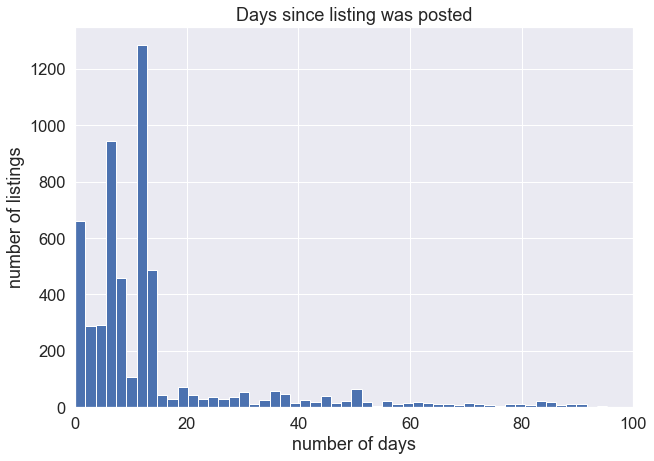

In [6]:
sns.set(font_scale=1.5)
plt.figure(figsize=(10, 7))
plt.hist(df.days_old, bins=300)
#plt.xscale('log')
plt.xlim(0, 100)
plt.title('Days since listing was posted')
plt.xlabel('number of days')
plt.ylabel('number of listings');

The next few cells will focus on the "home types" column. It wasn't possible to change this to a binary column before because there are too many different types of home. However, studios and lofts are really just types of apartment, and since we have so few of each, we will lump them together with apartments. Also, as we are only interested in plots of land with houses, we will lump them together with houses. First we will have a look at the spread of prices for different types of home to make sure there are no huge differences.

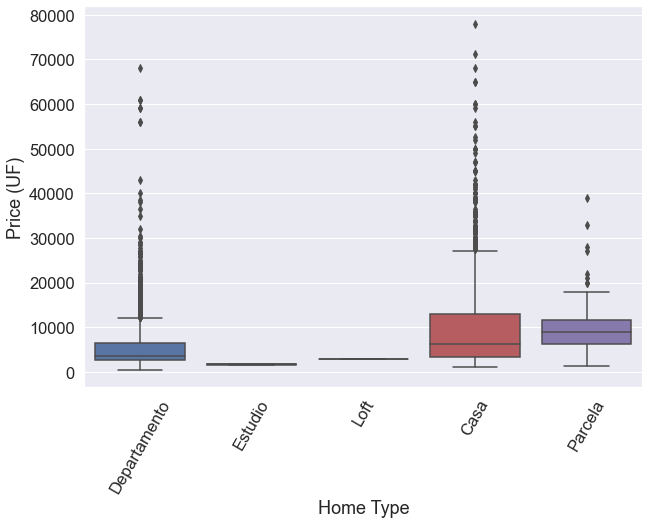

In [7]:
# Box plots showing price distribution by home type
sns.set(font_scale=1.5)
plt.figure(figsize=(10, 7))
sns.boxplot(x='home_type', y='price_uf', data=df)
plt.xticks(rotation=60)
plt.ylabel('Price (UF)')
plt.xlabel('Home Type');

In [8]:
# Check value counts
df.home_type.value_counts()

Departamento    3377
Casa            2063
Parcela          187
Estudio            4
Loft               1
Name: home_type, dtype: int64

In [9]:
# Convert home types to "house" or "apartment"
df.loc[df['home_type'] == 'Parcela', 'home_type'] = 'Casa'
df.loc[df['home_type'] == 'Estudio', 'home_type'] = 'Departamento'
df.loc[df['home_type'] == 'Loft', 'home_type'] = 'Departamento'

In [10]:
# Confirm change is done
df.home_type.value_counts()

Departamento    3382
Casa            2250
Name: home_type, dtype: int64

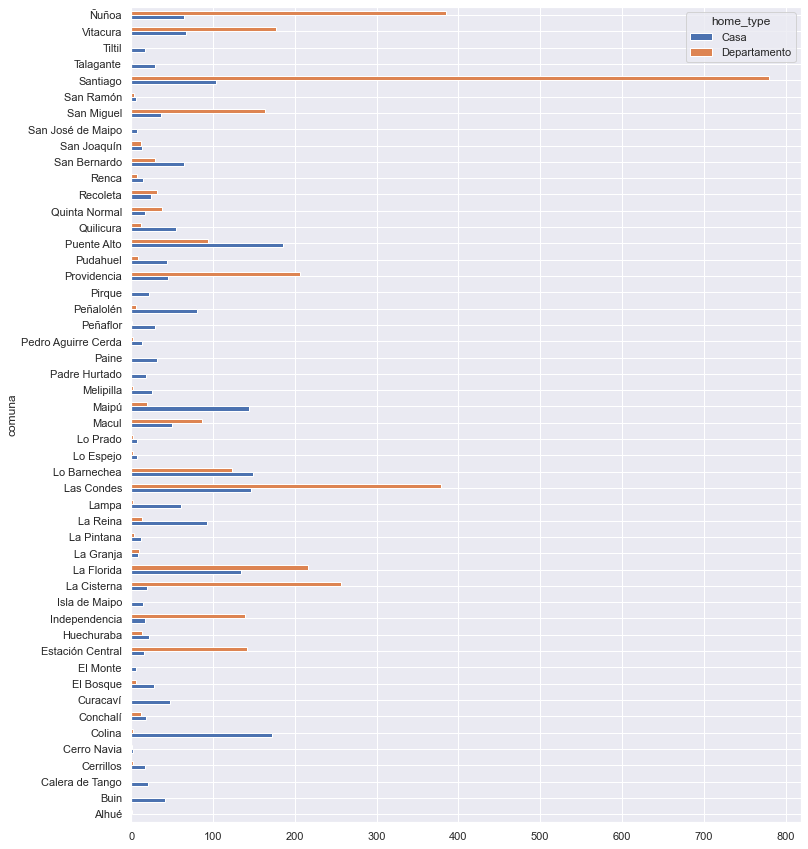

In [11]:
# Show numbers of houses or apartments by comuna
sns.set(font_scale=1)
grouped = df[['comuna', 'home_type']].value_counts().unstack()
grouped = grouped.fillna(0)
grouped.plot(kind='barh', figsize=(12, 15));

In [12]:
# Change "home_type" to a binary column
mapping = {'Casa': 1, 'Departamento': 0}
df.home_type = df.home_type.replace(mapping)
df.rename(columns={'home_type': 'house'}, inplace=True)
df.new.dtype

dtype('int64')

Now that we have added two new numerical features, we will perform some general analysis on all of the numerical features and take a look at how they relate to each other. First, with the `describe()` function we see that the new "house" feature (0 for apartment, 1 for house) is less imbalanced than the other binary features. The "days old" feature is heavily right-skewed, much like the the area and price features.

In [13]:
# Get summary statistics for numerical columns
df.describe().T

,count,mean,std,min,25%,50%,75%,max
house,5632.0,0.399503,0.489840,0.00,0.00,0.00,1.00,1.0
new,5632.0,0.009055,0.094736,0.00,0.00,0.00,0.00,1.0
total_area,4015.0,746.428685,2432.875777,18.00,67.00,135.00,328.00,49000.0
built_area,2203.0,175.827776,128.143464,30.00,92.00,139.00,215.00,1400.0
bedrooms,5603.0,2.964483,1.429026,1.00,2.00,3.00,4.00,16.0
bathrooms,5500.0,2.174909,1.151210,1.00,1.00,2.00,3.00,12.0
furnished,5632.0,0.020064,0.140231,0.00,0.00,0.00,0.00,1.0
price_uf,5632.0,7111.248326,7228.270177,522.85,2888.98,4182.83,9062.79,78000.0
days_old,5632.0,17.698153,33.526339,0.00,6.00,11.00,13.00,550.0


Remember that all of these statistics come from the data on the website on a particular day. How different might we expect the data to be on a different day? How closely do they approximate the "true" values, for example the real mean number of bathrooms for a home in Chile's Metropolitan Region? The function below takes adavntage of the Central Limit Theorem, which states that if enough samples are taken from a population, the distribution of sample means will approximate a normal distribution, regardless of the underlying distribution of the population. The function identifies the numerical features of a DataFrame and returns a confidence interval for the "true" mean of each of those features.

In [14]:
# Returns a dictionary of confidence intervals for all numerical features of a dataframe
def mean_confidence_intervals(df, confidence_level):
    
    num_features = []
    
    for col in list(df.columns):
        if df[col].dtype in ['int64', 'float64']:
            num_features.append(col)
    
    intervals = []
    
    for feature in num_features:
        degrees_freedom = df[feature].count() - 1
        sample_mean = df[feature].mean()
        sample_standard_error = stats.sem(df[feature], nan_policy='omit')
        confidence_interval = stats.t.interval(confidence_level, degrees_freedom, sample_mean, sample_standard_error)
        if confidence_interval[0] < 0:
            confidence_interval = (0, confidence_interval[1])
        intervals.append(confidence_interval)
        
    return dict(zip(num_features, intervals))

Now we try out the function all the entire dataset, first with a 90% confidence interval, and then a 99% confidence interval. The 99% intervals will be wider than the 90% intervals.

In [15]:
# 90% confidence intervals for population means
mean_confidence_intervals(df, 0.90)

{'house': (0.3887648912963727, 0.410240790521809),
 'new': (0.006978646860742087, 0.011132148593803369),
 'total_area': (683.259589435688, 809.5977804273256),
 'built_area': (171.33516061489098, 180.32039090576265),
 'bedrooms': (2.9330761326096066, 2.9958904924127028),
 'bathrooms': (2.149371873086342, 2.20044630873184),
 'furnished': (0.016989857765229967, 0.02313798314386094),
 'price_uf': (6952.794851760494, 7269.701799517915),
 'days_old': (16.96321063645548, 18.43309618172634)}

In [16]:
# 99% confidence intervals for population means
mean_confidence_intervals(df, 0.99)

{'house': (0.38268435235209225, 0.4163213294660895),
 'new': (0.005802652841683617, 0.012308142612861839),
 'total_area': (647.4821028734168, 845.3752669895969),
 'built_area': (168.78923080625725, 182.8663207143964),
 'bedrooms': (2.9152912607632024, 3.013675364259107),
 'bathrooms': (2.1349108397939185, 2.2149073420242633),
 'furnished': (0.015249119675212915, 0.024878721233877996),
 'price_uf': (6863.067990159759, 7359.42866111865),
 'days_old': (16.547037315476746, 18.849269502705074)}

Next we will look at two different *comunas*, each with 95% confidence intervals. The first one, San Ramón, is a poor *comuna* with very few listings. Because we have so few listings, the confidence intervals are quite wide (signifying a lack of confidence). Also, the intervals for price, number of bathrooms, built area, and total area are significantly lower that those of the dataset as a whole, while the interval for number of bedrooms is slightly higher. We can deduce that in this *comuna*, people live in smaller homes with fewer bathrooms per occupant. 

In [17]:
# 95% confidence intervals for population means in central San Ramón
san_ramon = df[df.comuna == 'San Ramón']
mean_confidence_intervals(san_ramon, 0.95)

/Users/roberthollomanwalker/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:2023: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/Users/roberthollomanwalker/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:2024: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


{'house': (0.192318066426846, 1.057681933573154),
 'new': (nan, nan),
 'total_area': (51.81884130289558, 276.1811586971044),
 'built_area': (54.40978814582701, 179.590211854173),
 'bedrooms': (2.6784386370367304, 4.821561362963269),
 'bathrooms': (0.8294219686237125, 1.4205780313762875),
 'furnished': (nan, nan),
 'price_uf': (1388.9693015928929, 3978.990698407107),
 'days_old': (13.484193251533974, 50.01580674846603)}

The second *comuna*, Las Condes, is one of the wealthiest *comunas*, and has quite a few listings. Notice that the intervals are narrower, indicating greater confidence, although still wider than the confidence intervals for the dataset as a whole. Also, the intervals for price, bathrooms, and built area are higher. For both of these *comunas* there are null values for the "new" feature, indicating that there are no new homes for sale in either *comuna*.

In [18]:
# 95% confidence intervals for population means in central Las Condes
las_condes = df[df.comuna == 'Las Condes']
mean_confidence_intervals(las_condes, 0.95)

{'house': (0.23964283782193485, 0.3165476383685414),
 'new': (nan, nan),
 'total_area': (267.23786049976553, 337.8476395002345),
 'built_area': (214.76342355666023, 259.12747299506384),
 'bedrooms': (3.1311601387482813, 3.3297922422040993),
 'bathrooms': (2.6141250661060647, 2.7953237527915733),
 'furnished': (0.00866086855036979, 0.03324389335439211),
 'price_uf': (12623.64635511822, 14043.910825834158),
 'days_old': (11.515036203639928, 16.012582843979118)}

The cell below contains a correlation heat map, showing the extent to which all of the features correlate with one another. Ultimately we will be most interested in how each of feature correlates with price, since this will be our target feature. The features that correlate most with price are built area and bathrooms.  The "days old" feature we created has virtually no correlation with price. The correlation between the columns "house" and built area is null, because apartments have no value for built area.

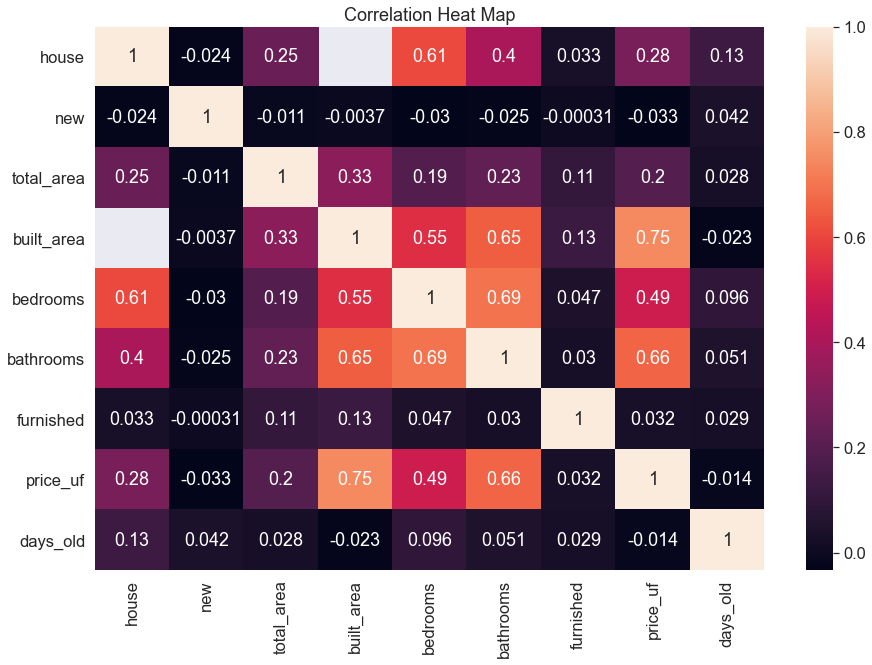

In [19]:
# Correlation Heatmap
sns.set(font_scale=1.5)
plt.figure(figsize=(15, 10))
sns.heatmap(df.corr(), annot=True)
plt.title('Correlation Heat Map');

For a more detailed view of the relationships between the features, we can create a pair plot. This is a series scatter plots between each pair of features, as well as a histogram for each feature down the diagonal axis. This will reveal any interesting relationships that are not captured by correlation.

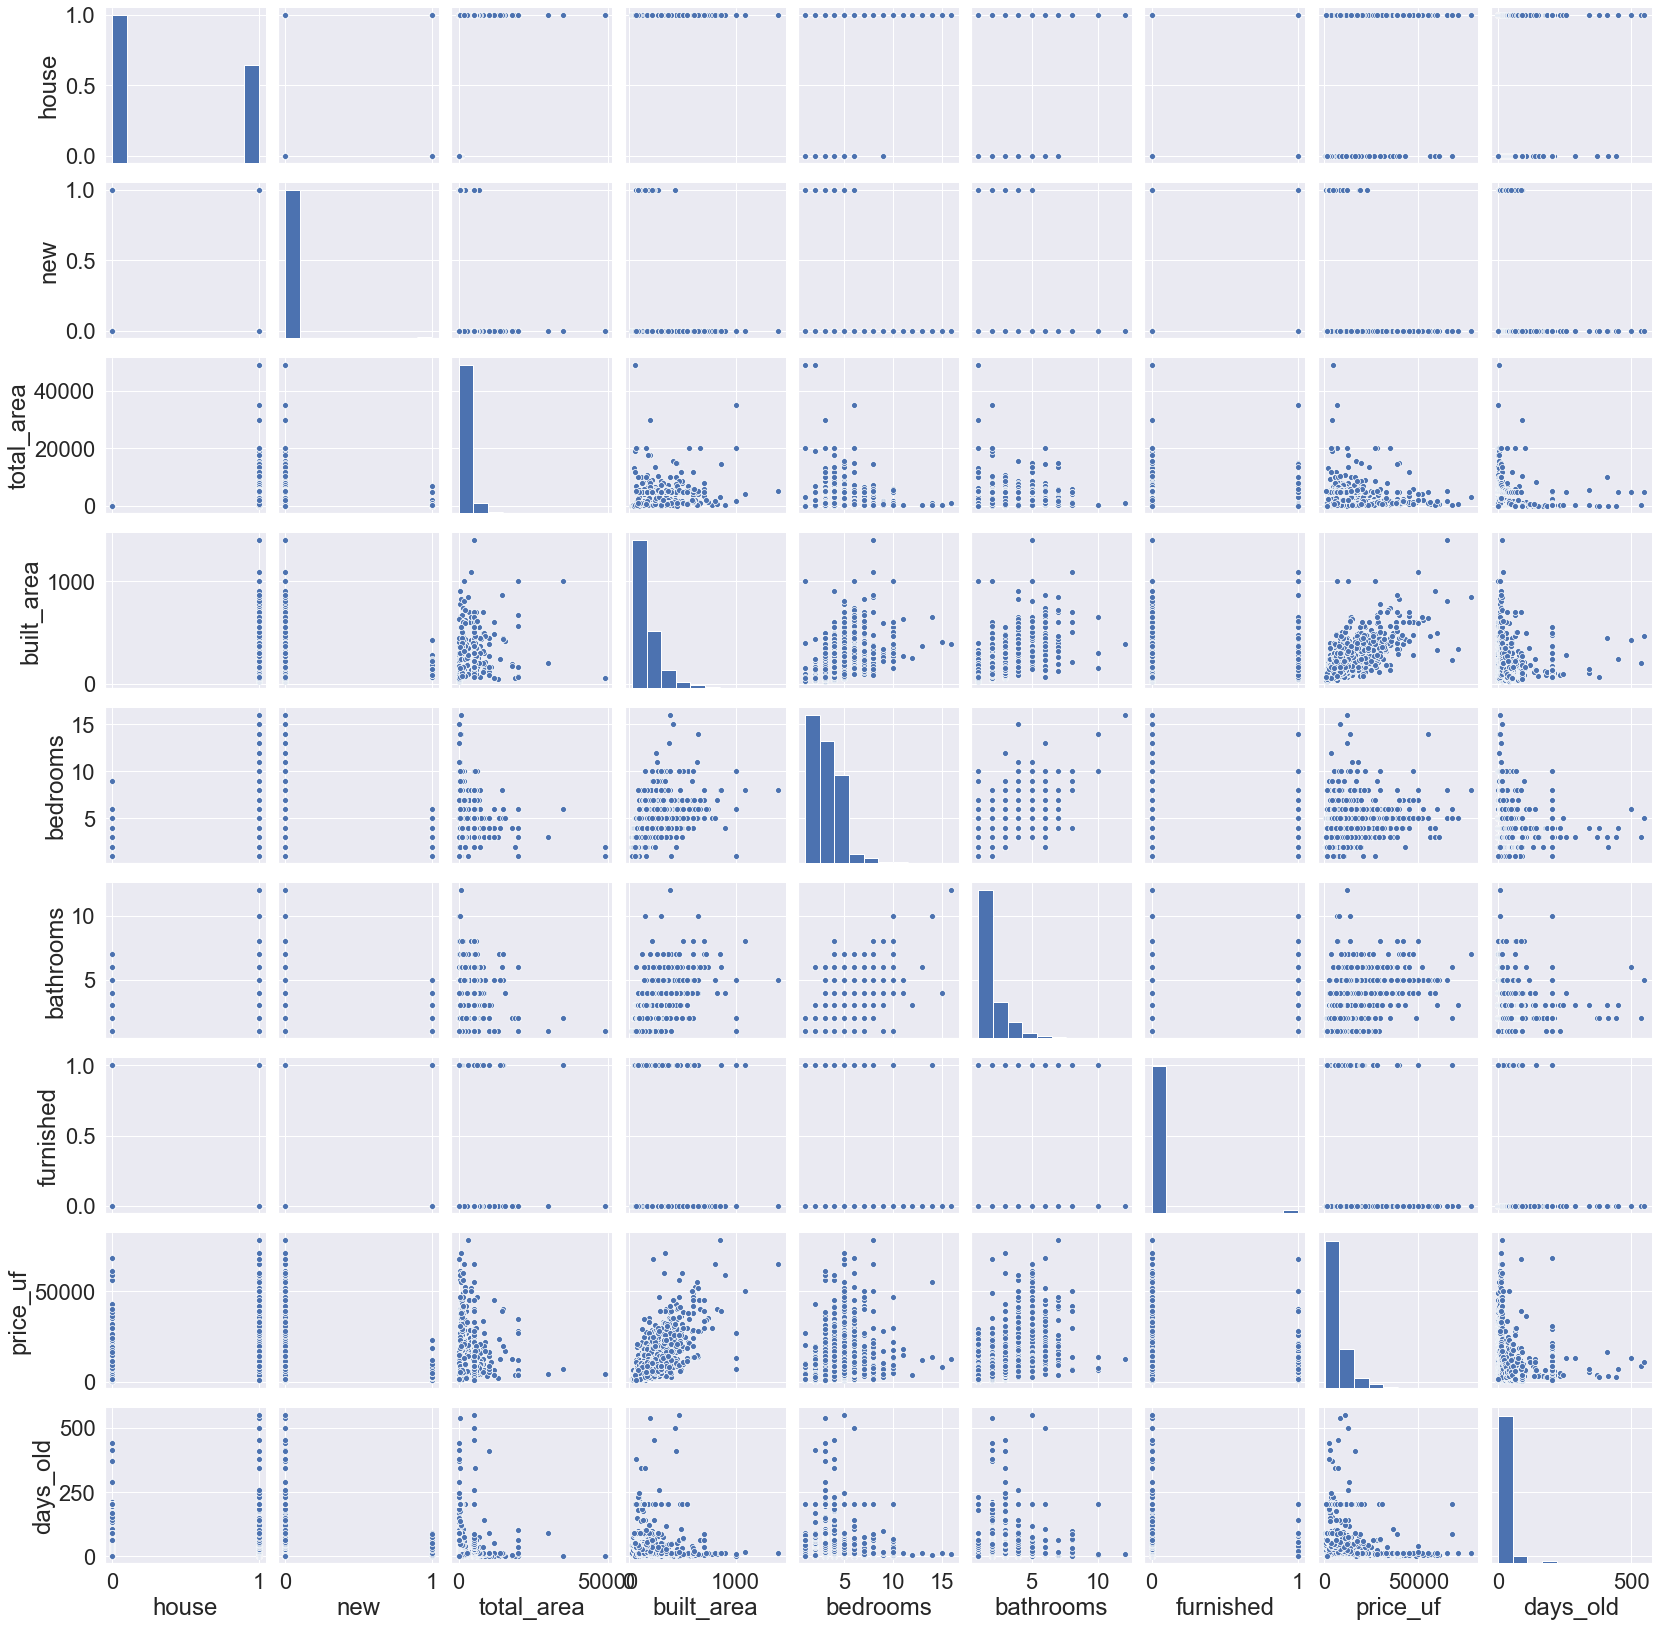

In [20]:
sns.set(font_scale=2)
sns.pairplot(df);

We will spend most of the rest of this notebook looking at the differences between the *comunas*, starting with the spread of the prices for each one. 

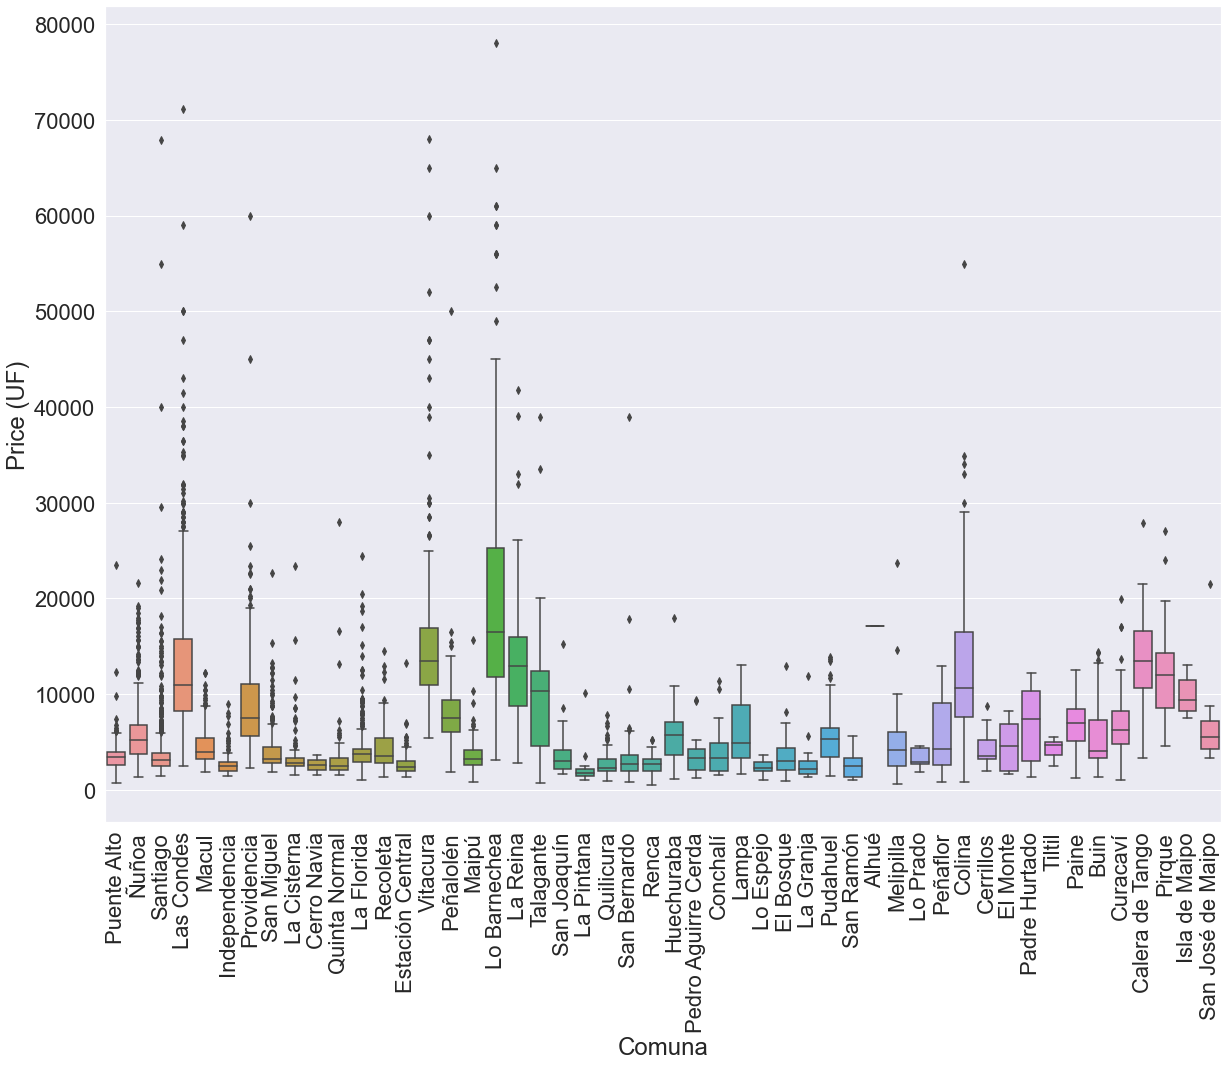

In [21]:
# Box plots of price by comuna
sns.set(font_scale=2)
plt.figure(figsize=(20, 15))
sns.boxplot(x='comuna', y='price_uf', data=df)
plt.xticks(rotation='vertical')
plt.ylabel('Price (UF)')
plt.xlabel('Comuna');

The Metropolitan Region of Chile has 52 *comunas* in total, 50 of which appear in our data. This will cause problems in the machine learning stage of the project, so it will be necessary to group the *comunas*. The function below groups the *comunas* into nine different zones representing different parts of the city and the surrounding areas.

In [22]:
def group_comunas(comuna):
    
    mapping = {'Santiago': 'center', 'Conchalí': 'north', 'Huechuraba': 'north', 'Independencia': 'north',
               'Recoleta': 'north', 'Renca': 'north', 'Quilicura': 'north', 'Las Condes': 'northeast', 
               'Lo Barnechea': 'rural east', 'Providencia': 'northeast', 'Vitacura': 'northeast', 'La Reina': 'east', 
               'Macul': 'east', 'Ñuñoa': 'east', 'Peñalolén': 'east', 'La Florida': 'southeast', 
               'La Granja': 'southeast', 'Puente Alto': 'southeast', 'El Bosque': 'south', 'La Cisterna': 'south', 
               'La Pintana': 'south', 'Lo Espejo': 'south', 'Pedro Aguirre Cerda': 'south', 'San Bernardo': 'south', 
               'San Joaquín': 'south', 'San Miguel': 'south', 'San Ramón': 'south', 'Cerrillos': 'west', 
               'Estación Central': 'west', 'Maipú': 'west', 'Cerro Navia': 'west', 'Lo Prado': 'west', 
               'Pudahuel': 'west', 'Quinta Normal': 'west', 'Alhué': 'rural west', 'Buin': 'rural west', 
               'Colina': 'rural east', 'Curacaví': 'rural west', 'Calera de Tango': 'rural west', 
               'El Monte': 'rural west', 'Isla de Maipo': 'rural west', 'Lampa': 'rural west', 
               'Melipilla': 'rural west', 'Padre Hurtado': 'rural west', 'Paine': 'rural west', 
               'Peñaflor': 'rural west', 'Pirque': 'rural east', 'San José de Maipo': 'rural east', 
               'Talagante': 'rural west', 'Tiltil': 'rural west', 'María Pinto': 'rural west', 
               'San Pedro': 'rural west'}
    
    try:
        return mapping[comuna]
    except:
        return comuna

In [23]:
# Apply the function
df['zone'] = df['comuna'].apply(group_comunas)
df.head()

,date,comuna,house,new,total_area,built_area,bedrooms,bathrooms,furnished,address,description,price_uf,days_old,zone
0,2020-09-10,Puente Alto,0,0,42.0,NaN,2.0,1.0,0,"Puente Alto, Sgto Menadier 2779","Departamento ubicado en segundo piso, en plena...",871.42,0,southeast
1,2020-09-09,Ñuñoa,0,0,70.0,NaN,2.0,2.0,0,"Ñuñoa, Irarrázaval 1401",Depto Vista despejada 2D 2B E B *2 dormitorios...,4900.00,1,east
2,2020-09-09,Santiago,0,0,23.0,NaN,1.0,1.0,0,"Santiago, Huérfanos",Oportunidad Inversionistas o particulares. Ven...,1575.00,1,center
3,2020-09-09,Las Condes,0,0,163.0,NaN,3.0,4.0,0,"Santiago, Vespucio Norte","Vespucio Norte, Las Condes, Vendo confortable ...",13500.00,1,northeast
4,2020-09-09,Ñuñoa,0,0,85.0,NaN,3.0,1.0,0,"Ñuñoa, Fidias a 3 cuadras metro Ñuble",Amplio y luminoso departamento dúplex en Villa...,3346.26,1,east


In [24]:
df.zone.unique()

array(['southeast', 'east', 'center', 'northeast', 'north', 'south',
       'west', 'rural east', 'rural west'], dtype=object)

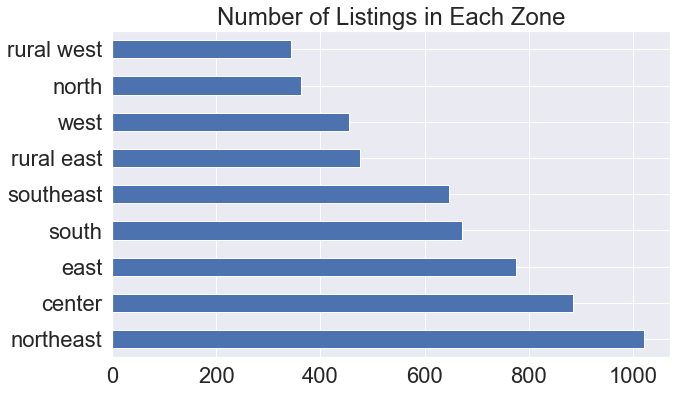

In [25]:
# Look at the results
df['zone'].value_counts().plot(kind='barh', figsize=(10, 6), title='Number of Listings in Each Zone');

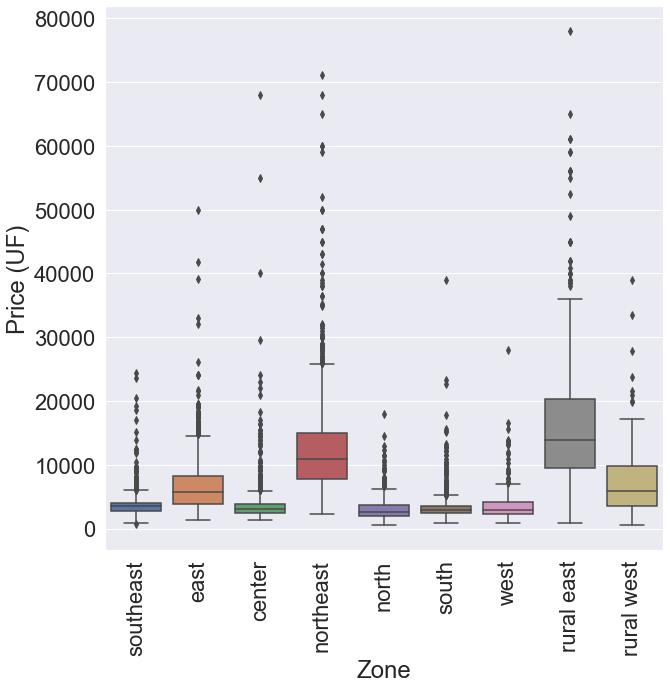

In [26]:
# Box plots of price by zone
sns.set(font_scale=2)
plt.figure(figsize=(10, 10))
sns.boxplot(x='zone', y='price_uf', data=df)
plt.xticks(rotation='vertical')
plt.ylabel('Price (UF)')
plt.xlabel('Zone');

Now we will make a Comunas DataFrame, containing the mean values by *comuna* for each feature, and afterward we will add a column for median price (so we can compare it to mean price) as well as a column for the number of listings per *comuna*. (We will look more at the zones later.)

In [27]:
# Make a dataframe of mean values by comuna for each feature
comunas_df = df.groupby('comuna').mean()
comunas_df.head()

,house,new,total_area,built_area,bedrooms,bathrooms,furnished,price_uf,days_old
comuna,,,,,,,,,
Alhué,0.000000,0.0,285.000000,NaN,3.000000,2.000000,0.000000,17100.000000,13.000000
Buin,1.000000,0.0,1236.846154,135.505366,3.707317,2.536585,0.097561,5694.965854,27.048780
Calera de Tango,1.000000,0.0,5153.600000,391.631579,5.368421,4.250000,0.200000,14026.146500,74.350000
Cerrillos,0.888889,0.0,219.388889,143.875000,3.888889,2.500000,0.000000,4233.536667,35.722222
Cerro Navia,0.666667,0.0,152.666667,129.000000,4.333333,1.333333,0.000000,2608.456667,17.666667


In [28]:
# Add columns for mean price and median price
comunas_df['med_price'] = df.groupby('comuna')['price_uf'].median()
comunas_df['listings_count'] = df.comuna.value_counts()
comunas_df.head()

,house,new,total_area,built_area,bedrooms,bathrooms,furnished,price_uf,days_old,med_price,listings_count
comuna,,,,,,,,,,,
Alhué,0.000000,0.0,285.000000,NaN,3.000000,2.000000,0.000000,17100.000000,13.000000,17100.000,1
Buin,1.000000,0.0,1236.846154,135.505366,3.707317,2.536585,0.097561,5694.965854,27.048780,4008.540,41
Calera de Tango,1.000000,0.0,5153.600000,391.631579,5.368421,4.250000,0.200000,14026.146500,74.350000,13500.000,20
Cerrillos,0.888889,0.0,219.388889,143.875000,3.888889,2.500000,0.000000,4233.536667,35.722222,3475.415,18
Cerro Navia,0.666667,0.0,152.666667,129.000000,4.333333,1.333333,0.000000,2608.456667,17.666667,2614.270,3


To gain more insight into how price and *comuna* are related we will create a scatter plot with mean price on the x-axis and median price on the y-axis. The size of the circle will correspond to the number of listings in the *comuna*. The red line shows perfect equivalence between mean and median. Most of the points are under the line, meaning that for those *comunas*, their means are larger than their medians. This is due to a few very expensive homes raising the averages.

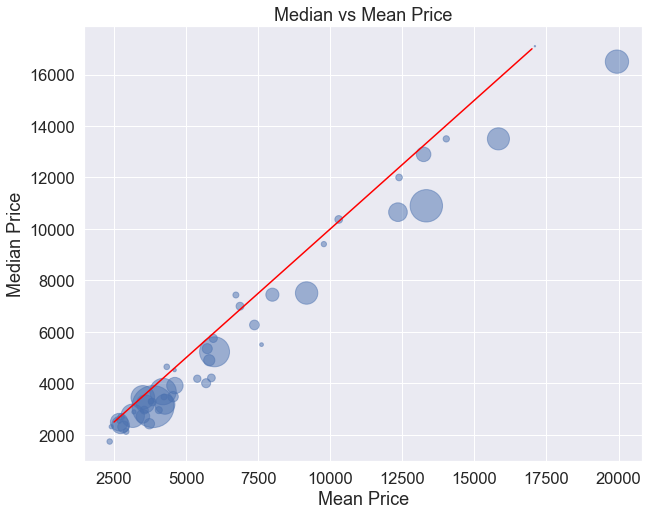

In [29]:
sns.set(font_scale=1.5)
X = comunas_df.price_uf
Y = comunas_df.med_price
S = comunas_df.listings_count
plt.figure(figsize=(10, 8))
plt.scatter(X, Y, S*2, alpha=0.5)
plt.plot([x for x in range(2500, 17000)],[x for x in range(2500, 17000)], color='red')
plt.title('Median vs Mean Price')
plt.xlabel('Mean Price')
plt.ylabel('Median Price');
#plt.annotate('Santiago', (3852.4, 3100));

In the final section of this notebook we will use vector maps to display the data from the Comunas DataFrame. We can find vector maps for all of the political boundaries within Chile on the website for the National Library of Congress of Chile (*Biblioteca del Congreso Nacional de Chile*): https://www.bcn.cl/siit/mapas_vectoriales

We will begin with a map showing the different regions of Chile to see where the Metropolitan Region is located. Chile is a highly elongated country with the regions more or less stacked vertically.  In the plot below, the Metropolitan Region is shown in orange. Barely visible on the far left side of the plot is the island of Rapa Nui (Easter Island), which is part of Chile.

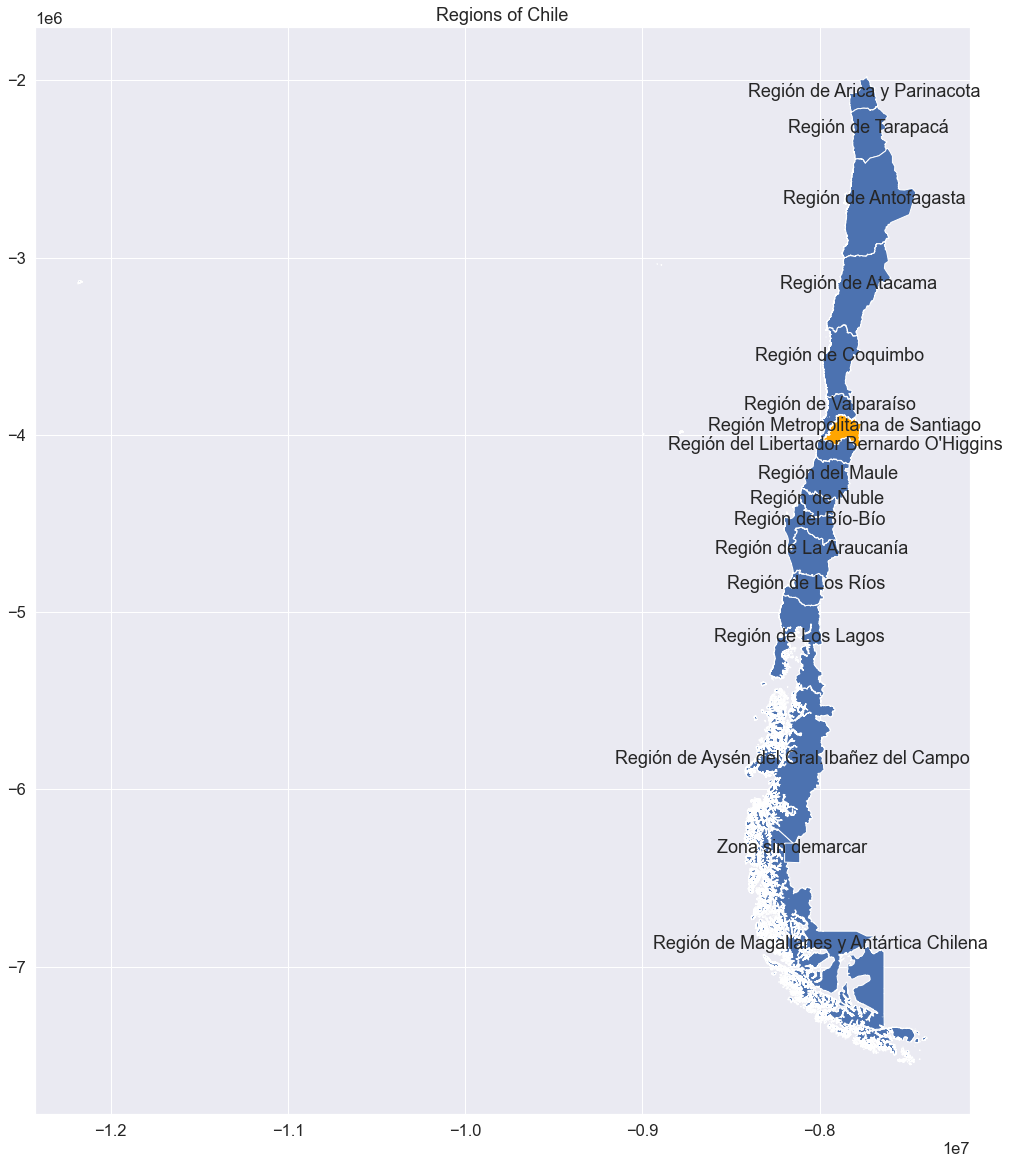

In [30]:
#Create GeoDataFrames with Geopandas
rmap_df = gpd.read_file('Regiones/Regional.shp', encoding='utf-8')
rmet = rmap_df[rmap_df['Region'] == 'Región Metropolitana de Santiago']

#Plot and annotate GeoDataframes
fig, ax = plt.subplots(1, figsize=(25, 20))
rmap_df.plot(ax=ax)
rmet.plot(ax=ax, color='orange')
rmap_df.apply(lambda x: ax.annotate(s=x.Region, xy=x.geometry.centroid.coords[0], ha='center'), axis=1)
plt.title('Regions of Chile');

Now we will look at the *comunas* that make up the Metropolitan Region. The regions of Chile can also be divided into provinces, each of which contains several comunas. This plot shows the provinces in the Metropolitan Region in different colors. 

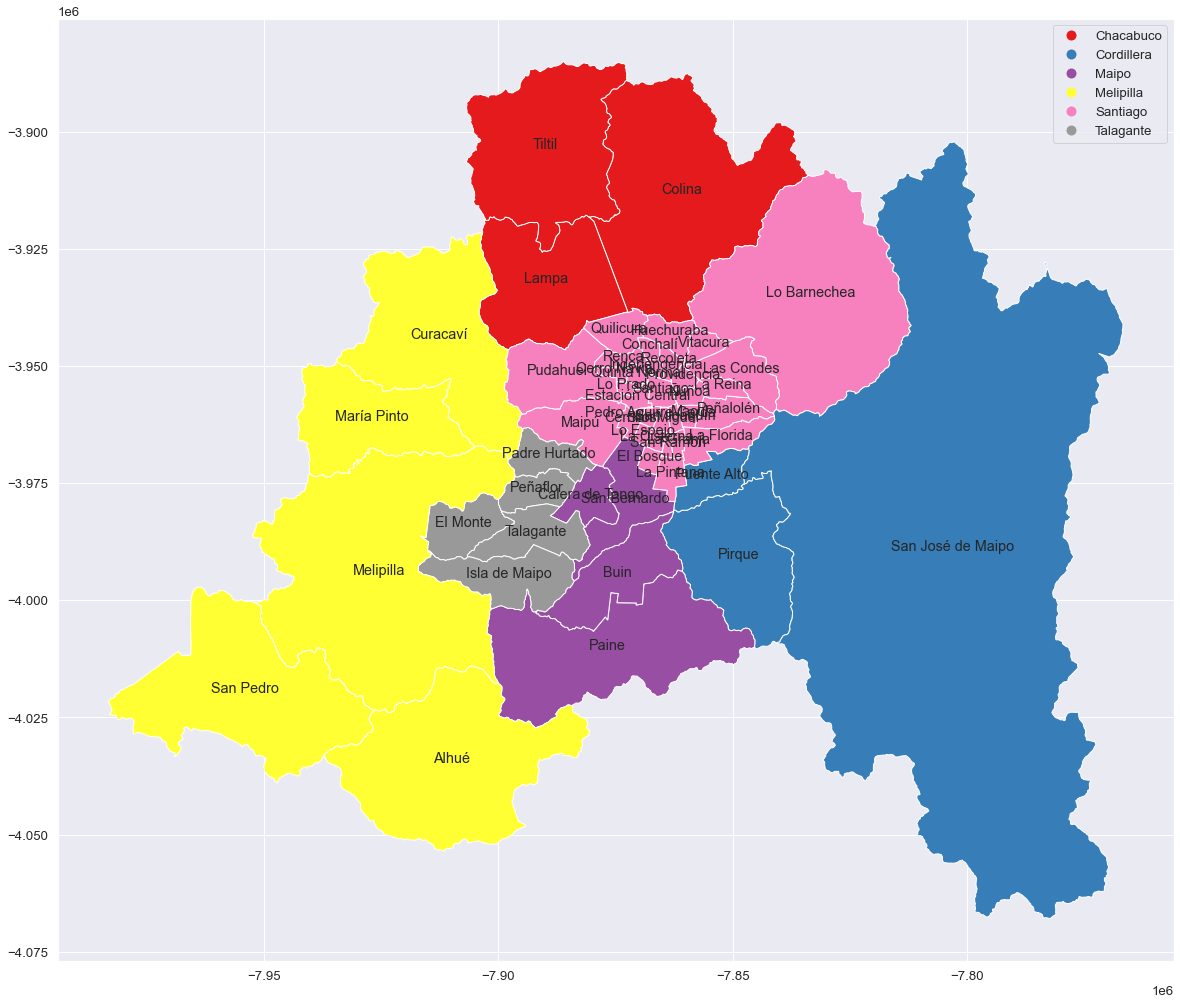

In [31]:
#Create GeoDataFrames with Geopandas
map_df = gpd.read_file('Comunas/comunas.shp', encoding='utf-8')
rm_df = map_df.loc[map_df.Region == 'Región Metropolitana de Santiago']

#Plot and annotate GeoDataframe
sns.set(font_scale=1.2)
ax = rm_df.plot(column='Provincia', cmap = 'Set1', figsize=(20, 20), legend=True)
rm_df.apply(lambda x: ax.annotate(s=x.Comuna, xy=x.geometry.centroid.coords[0], ha='center'), axis=1);

The plot below shows the province of Santiago, which is where almost all of the listings are located. This should not be confused with the *comuna* of Santiago, which is located inside the province of Santiago.

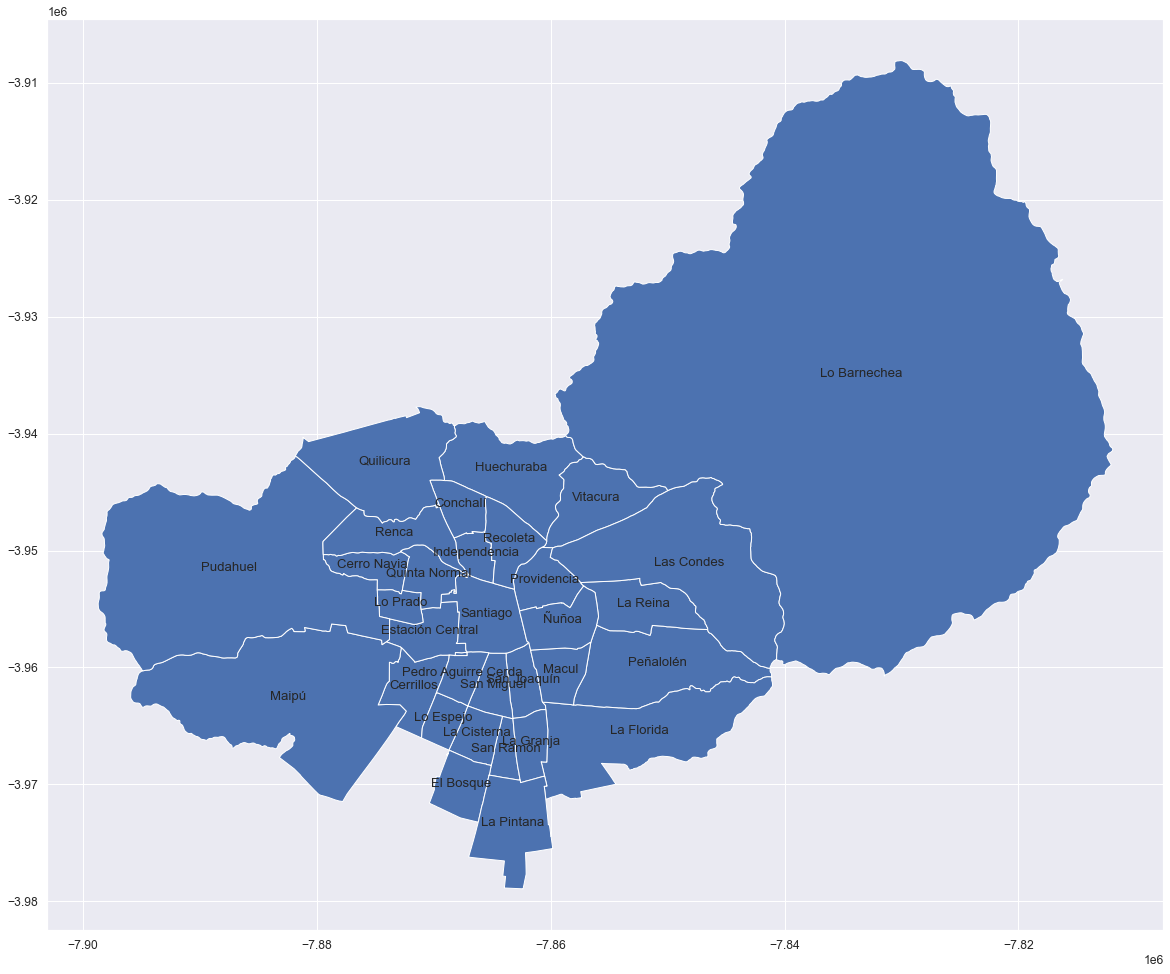

In [32]:
santiago_df = map_df.loc[map_df.Provincia == 'Santiago']
sns.set(font_scale=1.1)
ax = santiago_df.plot(figsize=(20, 20))
santiago_df.apply(lambda x: ax.annotate(s=x.Comuna, xy=x.geometry.centroid.coords[0], ha='center'), axis=1);

Next we will select only the relevant columns from the GeoDataFrame and merge them with our Comunas DataFrame to create a new GeoDataFrame, which we can use to plot our data.

In [33]:
geo_df = rm_df[['Comuna', 'geometry']].set_index('Comuna')
merged_df = geo_df.join(comunas_df)
merged_df['listings_count'] = merged_df['listings_count'].fillna(0)
merged_df.head()

,geometry,house,new,total_area,built_area,bedrooms,bathrooms,furnished,price_uf,days_old,med_price,listings_count
Comuna,,,,,,,,,,,,
San Joaquín,"POLYGON ((-7861762.687 -3958307.095, -7861708....",0.520000,0.000000,202.278947,146.307692,3.440000,1.583333,0.000000,4053.385200,17.320000,2962.840,25.0
San Miguel,"POLYGON ((-7863229.775 -3964360.652, -7863319....",0.180905,0.005025,153.997797,158.944444,2.723618,1.803030,0.015075,4267.154472,17.090452,3190.000,199.0
San Ramón,"POLYGON ((-7863398.118 -3964354.273, -7863319....",0.625000,0.000000,164.000000,117.000000,3.750000,1.125000,0.000000,2683.980000,31.750000,2527.125,8.0
Independencia,"POLYGON ((-7865631.125 -3948404.075, -7865643....",0.108974,0.019231,72.381915,128.500000,2.044872,1.258278,0.000000,2680.004038,19.955128,2495.000,156.0
La Cisterna,"POLYGON ((-7865040.615 -3968217.521, -7865077....",0.069091,0.010909,177.080000,155.842105,2.127273,1.440000,0.003636,3148.734545,11.836364,2744.000,275.0


Now we will begin plotting the data.  The first plot shows the number of listings per *comuna*, and the following graphs show different features. It is important to remember that since there are few listings in the outer *comunas*, the mean values can vary significantly, and are less reliable for making inferences about the comuna. The plot below includes *comunas* with zero listings.

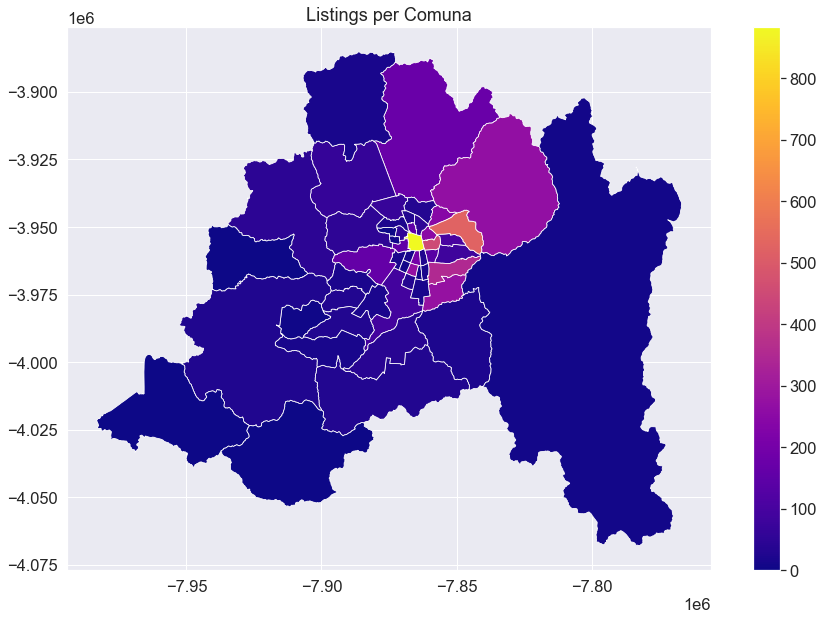

In [34]:
sns.set(font_scale=1.5)
fig, ax = plt.subplots(1, figsize=(15, 10))

merged_df.plot('listings_count', cmap='plasma', linewidth=0.8, ax=ax, legend=True)
plt.title('Listings per Comuna');

This plot shows the portion of homes for sale that are houses (as opposed to apartments). Not surprisingly, the rural *comunas* have mostly houses, while the urban *comunas* have mostly apartments. Notable exceptions are Lo Barnechea and Alhué. Lo Barnechea has many apartments despite being rural, probably due to the fact that it contains ski resorts. Alhué contains only one listing, which is supposedly an apartment (confirmed by the description), despite being in a very rural area. 

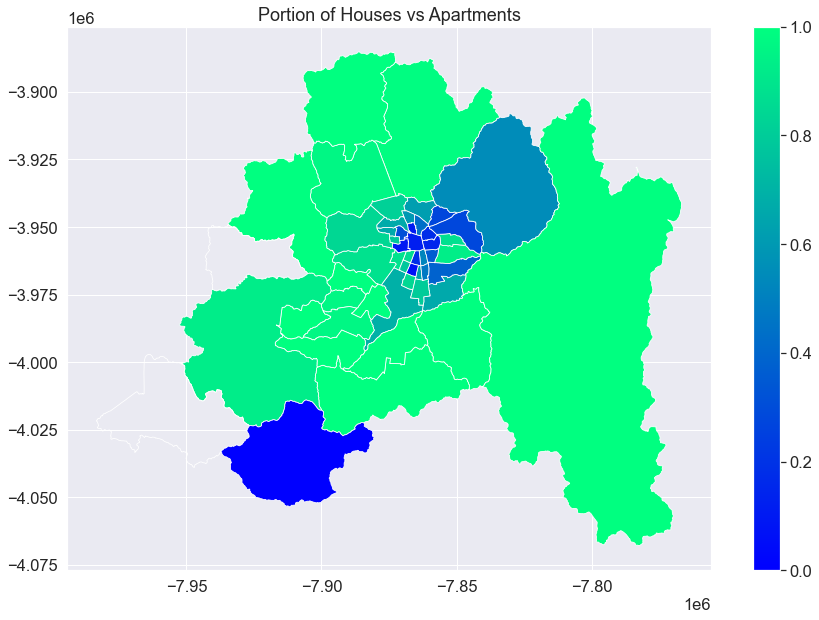

In [35]:
fig, ax = plt.subplots(1, figsize=(15, 10))

merged_df.plot('house', cmap='winter', linewidth=0.8, ax=ax, legend=True)
plt.title('Portion of Houses vs Apartments');

The next two plots show total area and built area. Total area refers to the total area of the property. Built area only exists for houses, and refers to the area of the house, as opposed to the property on which it is built. Both built area and total area tend to be higher in rural *comunas*, although built area is also higher in the more expensive *comunas*.

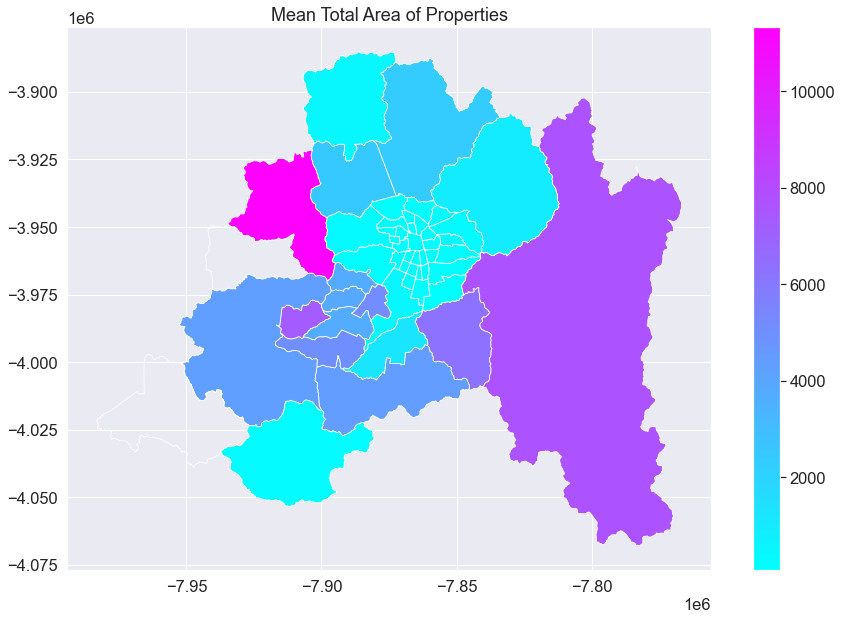

In [36]:
fig, ax = plt.subplots(1, figsize=(15, 10))

merged_df.plot('total_area', cmap='cool', linewidth=0.8, ax=ax, legend=True)
plt.title('Mean Total Area of Properties');

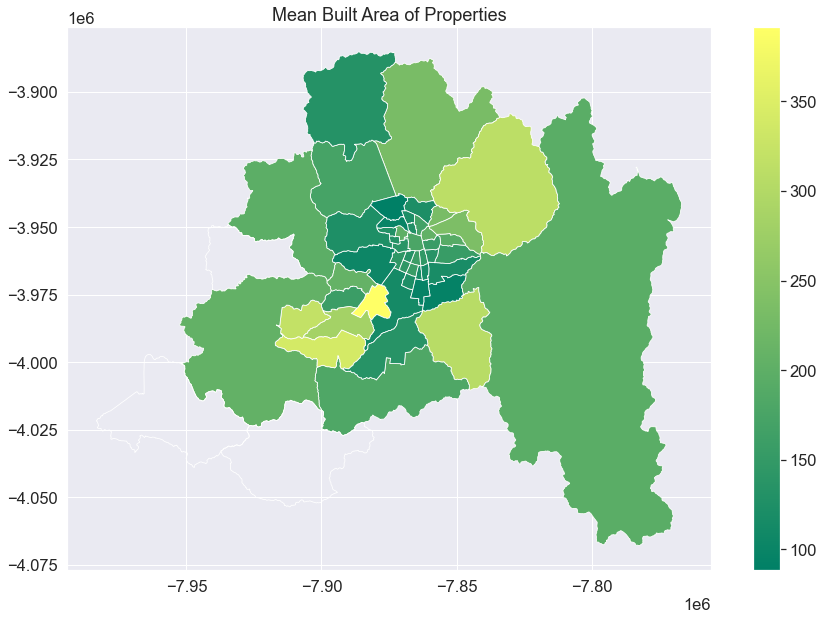

In [37]:
fig, ax = plt.subplots(1, figsize=(15, 10))

merged_df.plot('built_area', cmap='summer', linewidth=0.8, ax=ax, legend=True)
plt.title('Mean Built Area of Properties');

The average number of bedrooms and bathrooms also tends to be a bit higher in rural *comunas*.

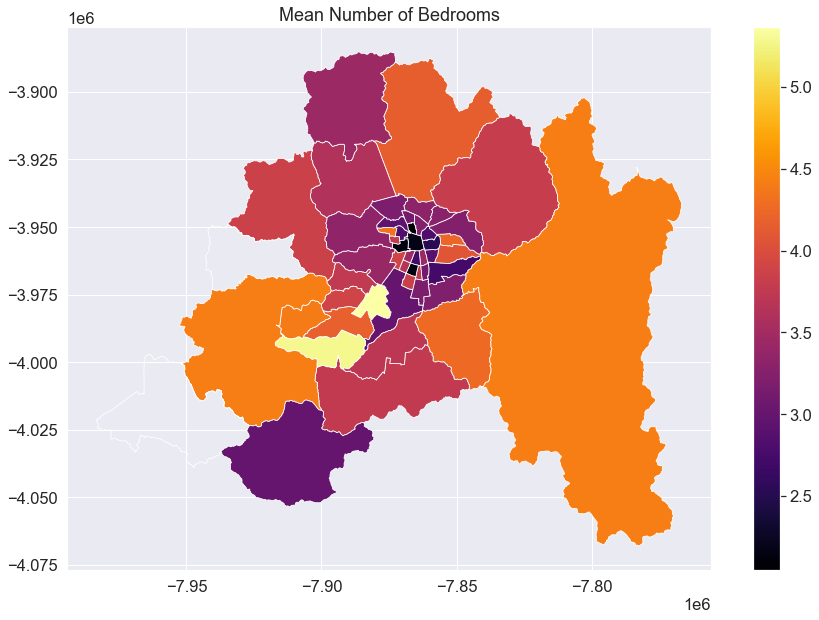

In [38]:
fig, ax = plt.subplots(1, figsize=(15, 10))

merged_df.plot('bedrooms', cmap='inferno', linewidth=0.8, ax=ax, legend=True)
plt.title('Mean Number of Bedrooms');

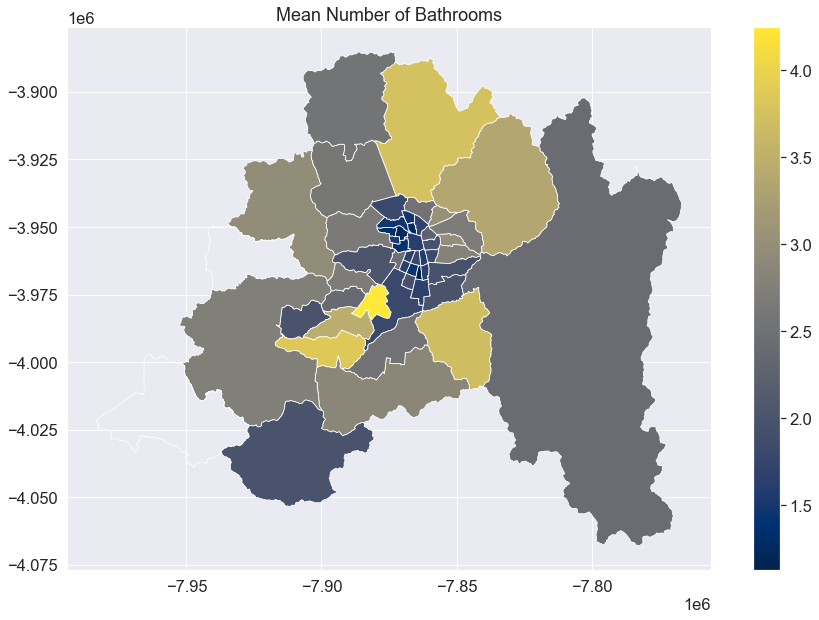

In [39]:
fig, ax = plt.subplots(1, figsize=(15, 10))

merged_df.plot('bathrooms', cmap='cividis', linewidth=0.8, ax=ax, legend=True)
plt.title('Mean Number of Bathrooms');

The last two plots show the mean number of days since the listing was posted, and the mean price in UF. It appears that some of the most expensive *comunas* also have many new listings. Particularly with the inner *comunas*, the more expensive ones are located in the northeast of the city.

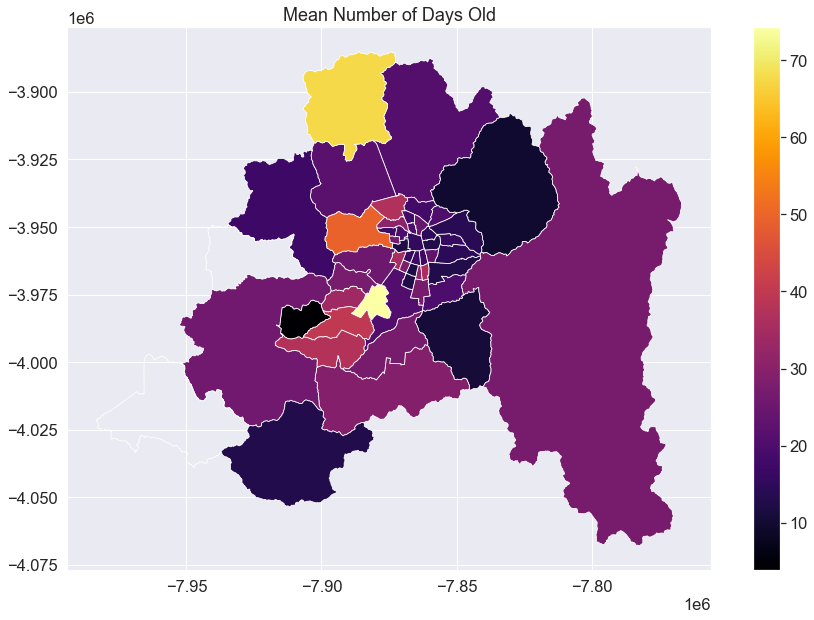

In [40]:
fig, ax = plt.subplots(1, figsize=(15, 10))

merged_df.plot('days_old', cmap='inferno', linewidth=0.8, ax=ax, legend=True)
plt.title('Mean Number of Days Old');

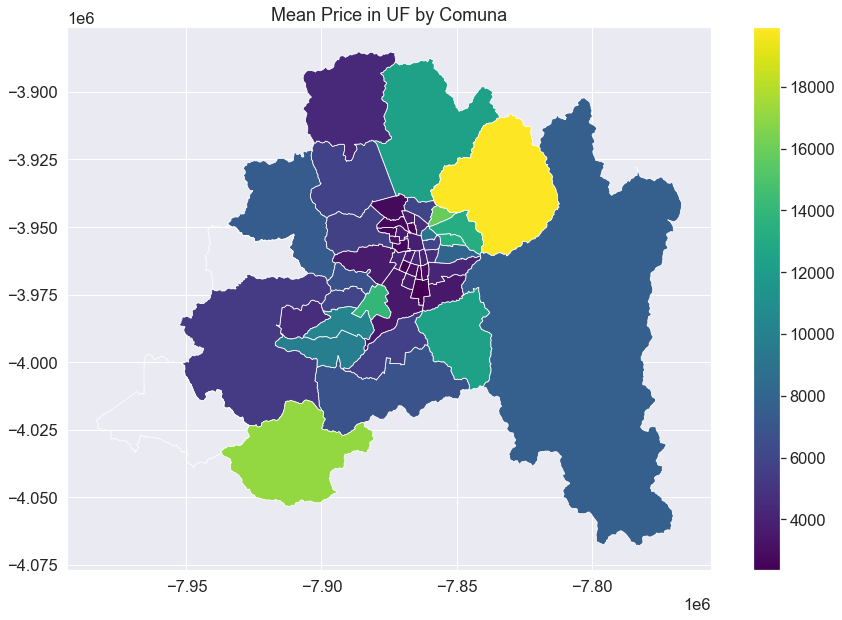

In [41]:
fig, ax = plt.subplots(1, figsize=(15, 10))

merged_df.plot('price_uf', cmap='viridis', linewidth=0.8, ax=ax, legend=True)
plt.title('Mean Price in UF by Comuna');

We will now repeat the visualizations, but showing zones instead of individual *comunas*. We can use the same mapping that we used before, adding a column to the GeoDataFrame we created before with the *comunas* and their polygons. Then we "dissolve" the polygons, merging them by zone.

In [42]:
mapping = {'Santiago': 'center', 'Conchalí': 'north', 'Huechuraba': 'north', 'Independencia': 'north', 
           'Recoleta': 'north', 'Renca': 'north', 'Quilicura': 'north', 'Las Condes': 'northeast', 
           'Lo Barnechea': 'rural east', 'Providencia': 'northeast', 'Vitacura': 'northeast', 'La Reina': 'east', 
           'Macul': 'east', 'Ñuñoa': 'east', 'Peñalolén': 'east', 'La Florida': 'southeast', 'La Granja': 'southeast', 
           'Puente Alto': 'southeast', 'El Bosque': 'south', 'La Cisterna': 'south', 'La Pintana': 'south', 
           'Lo Espejo': 'south', 'Pedro Aguirre Cerda': 'south', 'San Bernardo': 'south', 'San Joaquín': 'south', 
           'San Miguel': 'south', 'San Ramón': 'south', 'Cerrillos': 'west', 'Estación Central': 'west', 
           'Maipú': 'west', 'Cerro Navia': 'west', 'Lo Prado': 'west', 'Pudahuel': 'west', 'Quinta Normal': 'west', 
           'Alhué': 'rural west', 'Buin': 'rural west', 'Colina': 'rural east', 'Curacaví': 'rural west', 
           'Calera de Tango': 'rural west', 'El Monte': 'rural west', 'Isla de Maipo': 'rural west', 
           'Lampa': 'rural west', 'Melipilla': 'rural west', 'Padre Hurtado': 'rural west', 'Paine': 'rural west', 
           'Peñaflor': 'rural west', 'Pirque': 'rural east', 'San José de Maipo': 'rural east', 
           'Talagante': 'rural west', 'Tiltil': 'rural west', 'María Pinto': 'rural west', 'San Pedro': 'rural west'}

geo_df['zone'] = pd.Series(mapping)
geo_df.head()

,geometry,zone
Comuna,,
San Joaquín,"POLYGON ((-7861762.687 -3958307.095, -7861708....",south
San Miguel,"POLYGON ((-7863229.775 -3964360.652, -7863319....",south
San Ramón,"POLYGON ((-7863398.118 -3964354.273, -7863319....",south
Independencia,"POLYGON ((-7865631.125 -3948404.075, -7865643....",north
La Cisterna,"POLYGON ((-7865040.615 -3968217.521, -7865077....",south


In [43]:
zones_geo = geo_df.dissolve(by='zone')
zones_geo.head()

,geometry
zone,
center,"POLYGON ((-7864917.074 -3952801.626, -7864220...."
east,"POLYGON ((-7858043.220 -3963216.230, -7858060...."
north,"POLYGON ((-7864900.785 -3952806.255, -7864917...."
northeast,"POLYGON ((-7857423.649 -3952757.258, -7857423...."
rural east,"POLYGON ((-7840656.000 -4009161.293, -7840714...."


Now we will make a Zones DataFrame, containing the mean values by zone for each feature, like we did with *comunas* before. We will join this DataFrame with the GeoDataFrame we created above, and add value counts.

In [44]:
zones_df = df.groupby('zone').mean()
zones_df['listings_count'] = df.zone.value_counts()
zones_df

,house,new,total_area,built_area,bedrooms,bathrooms,furnished,price_uf,days_old,listings_count
zone,,,,,,,,,,
center,0.117647,0.005656,133.712651,178.113402,2.187215,1.619490,0.032805,3852.387048,15.700226,884
east,0.368557,0.007732,247.142224,164.291018,2.987063,2.161629,0.007732,6961.115735,15.070876,776
north,0.408840,0.008287,133.653786,115.419097,2.695291,1.574648,0.008287,3396.072127,24.113260,362
northeast,0.252941,0.002941,290.515424,230.193502,3.142296,2.673347,0.013725,12910.066333,15.603922,1020
rural east,0.736842,0.006316,1900.994134,270.329020,3.968220,3.513919,0.021053,16631.844295,14.208421,475
rural west,0.979651,0.011628,4432.616519,204.901770,3.987988,2.880597,0.075581,7097.872006,31.328488,344
south,0.292101,0.007452,240.795343,131.830158,2.649776,1.633028,0.013413,3562.966453,15.718331,671
southeast,0.506192,0.015480,176.597713,105.098765,2.951938,1.954041,0.010836,3863.910681,16.609907,646
west,0.537445,0.026432,161.726427,120.617300,2.929360,1.800915,0.019824,3561.537533,23.466960,454


In [45]:
zones_merged_df = zones_geo.join(zones_df)
zones_merged_df.head()

,geometry,house,new,total_area,built_area,bedrooms,bathrooms,furnished,price_uf,days_old,listings_count
zone,,,,,,,,,,,
center,"POLYGON ((-7864917.074 -3952801.626, -7864220....",0.117647,0.005656,133.712651,178.113402,2.187215,1.619490,0.032805,3852.387048,15.700226,884
east,"POLYGON ((-7858043.220 -3963216.230, -7858060....",0.368557,0.007732,247.142224,164.291018,2.987063,2.161629,0.007732,6961.115735,15.070876,776
north,"POLYGON ((-7864900.785 -3952806.255, -7864917....",0.408840,0.008287,133.653786,115.419097,2.695291,1.574648,0.008287,3396.072127,24.113260,362
northeast,"POLYGON ((-7857423.649 -3952757.258, -7857423....",0.252941,0.002941,290.515424,230.193502,3.142296,2.673347,0.013725,12910.066333,15.603922,1020
rural east,"POLYGON ((-7840656.000 -4009161.293, -7840714....",0.736842,0.006316,1900.994134,270.329020,3.968220,3.513919,0.021053,16631.844295,14.208421,475


Finally, we repeat the plots from above, this time using zones instead of *comunas*.  The good news is that all of the zones have at least several hundred listings, making the mean values much more robust than before.  Most of the results are not surprising, although it is notable that the listings in the "rural east" zone are significantly more expensive and sell much faster than those in "rural west".  The homes in "rural east" also tend to be larger, but are built on smaller plots of land than "rural west".

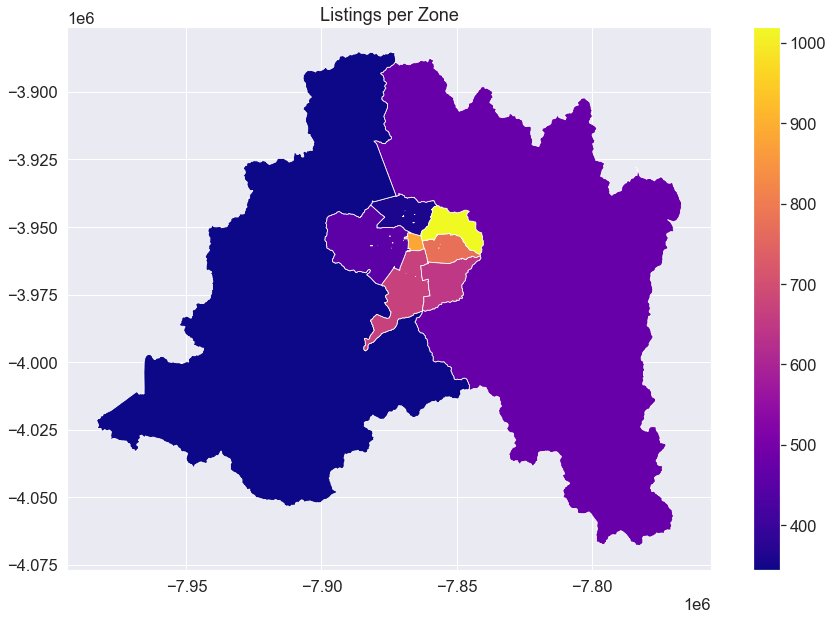

In [46]:
sns.set(font_scale=1.5)
fig, ax = plt.subplots(1, figsize=(15, 10))

zones_merged_df.plot('listings_count', cmap='plasma', linewidth=0.8, ax=ax, legend=True)
plt.title('Listings per Zone');

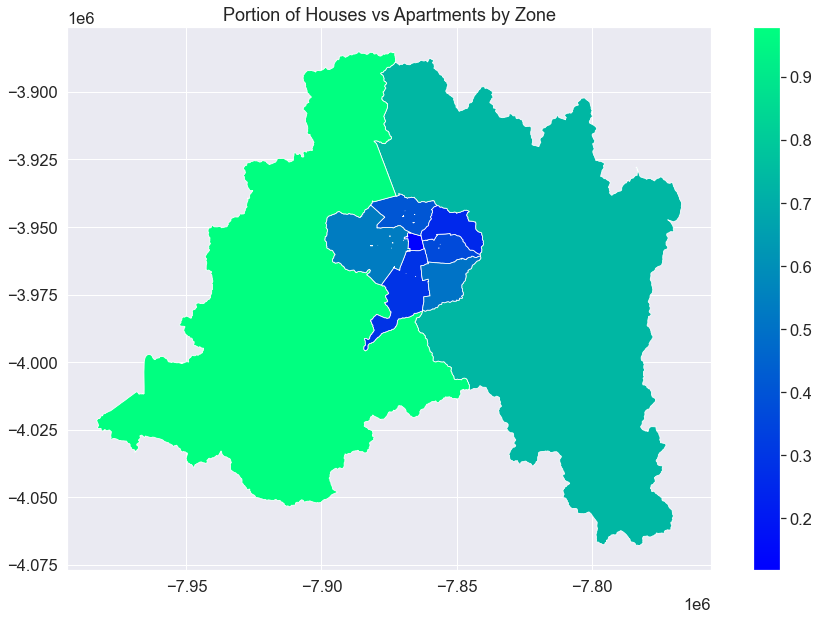

In [47]:
fig, ax = plt.subplots(1, figsize=(15, 10))

zones_merged_df.plot('house', cmap='winter', linewidth=0.8, ax=ax, legend=True)
plt.title('Portion of Houses vs Apartments by Zone');

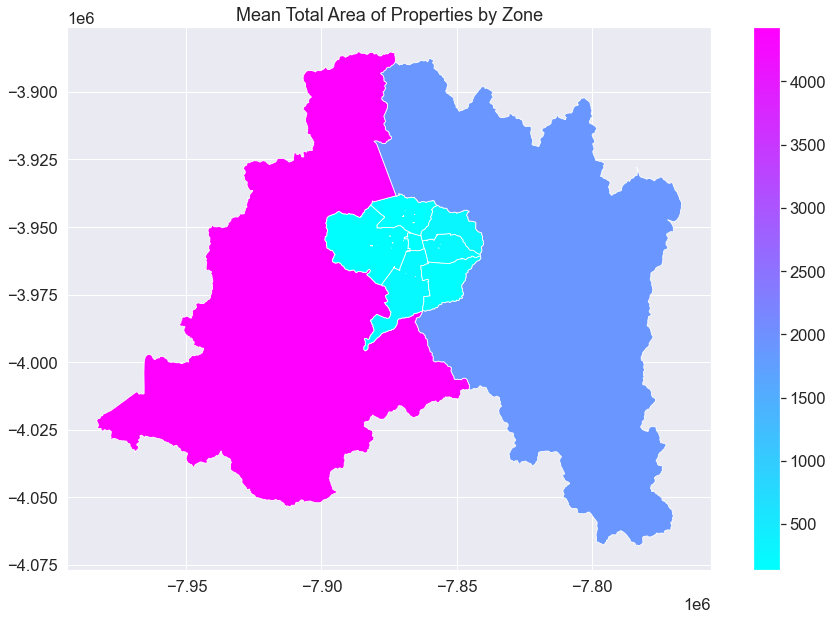

In [48]:
fig, ax = plt.subplots(1, figsize=(15, 10))

zones_merged_df.plot('total_area', cmap='cool', linewidth=0.8, ax=ax, legend=True)
plt.title('Mean Total Area of Properties by Zone');

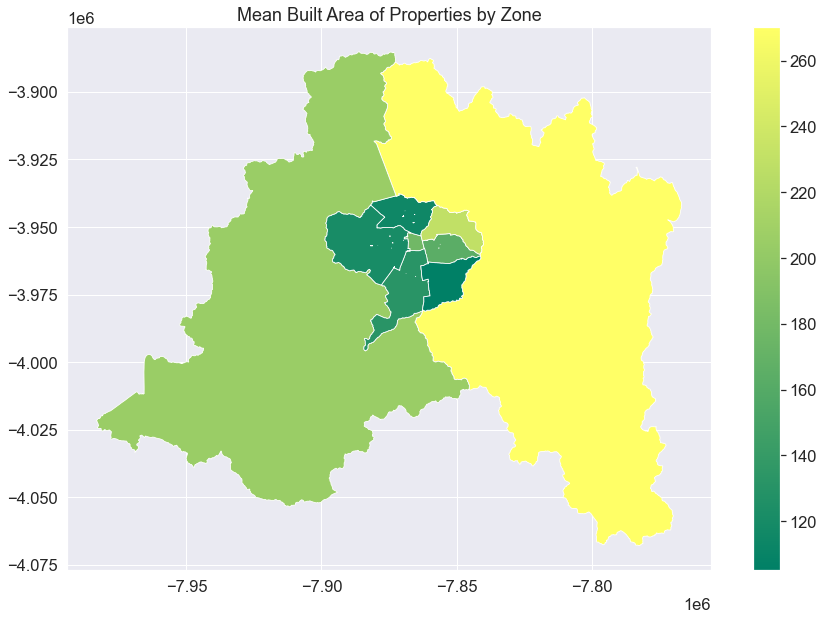

In [49]:
fig, ax = plt.subplots(1, figsize=(15, 10))

zones_merged_df.plot('built_area', cmap='summer', linewidth=0.8, ax=ax, legend=True)
plt.title('Mean Built Area of Properties by Zone');

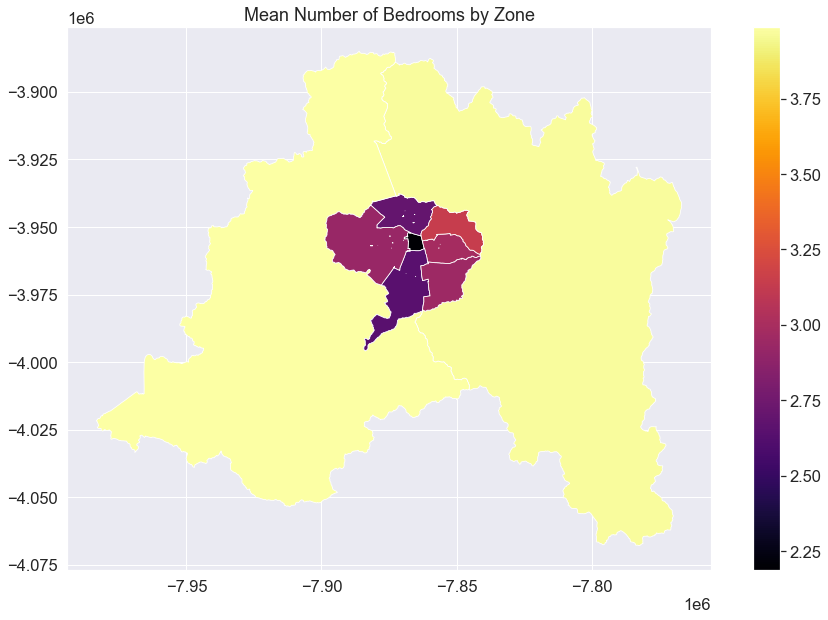

In [50]:
fig, ax = plt.subplots(1, figsize=(15, 10))

zones_merged_df.plot('bedrooms', cmap='inferno', linewidth=0.8, ax=ax, legend=True)
plt.title('Mean Number of Bedrooms by Zone');

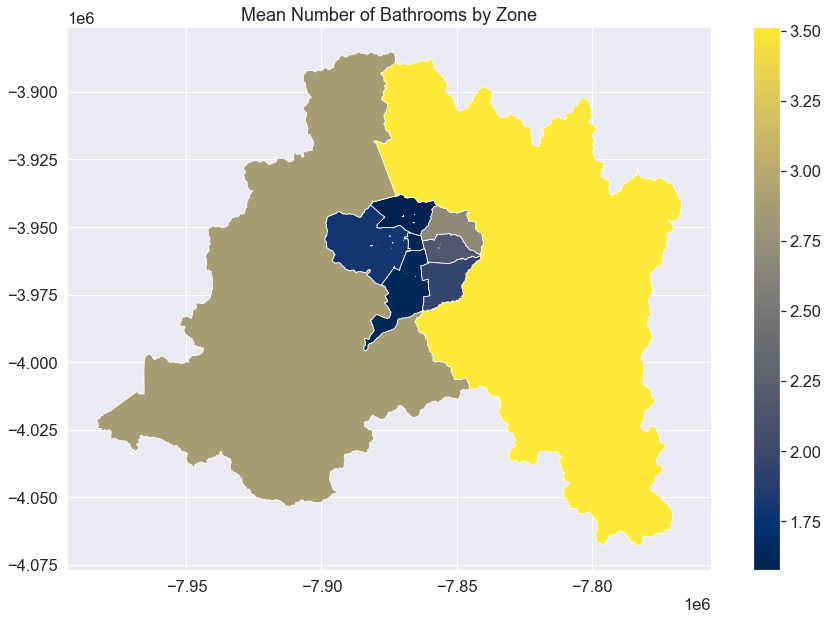

In [51]:
fig, ax = plt.subplots(1, figsize=(15, 10))

zones_merged_df.plot('bathrooms', cmap='cividis', linewidth=0.8, ax=ax, legend=True)
plt.title('Mean Number of Bathrooms by Zone');

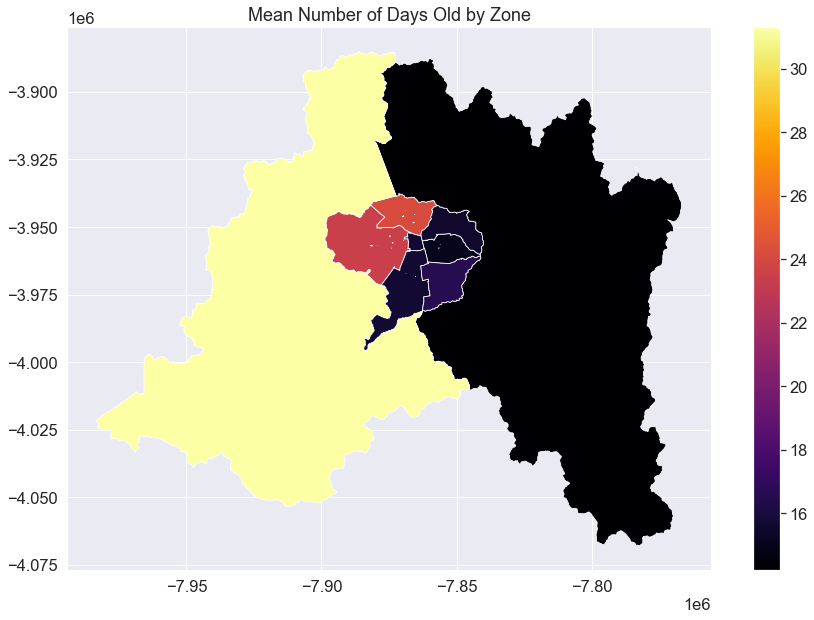

In [52]:
fig, ax = plt.subplots(1, figsize=(15, 10))

zones_merged_df.plot('days_old', cmap='inferno', linewidth=0.8, ax=ax, legend=True)
plt.title('Mean Number of Days Old by Zone');

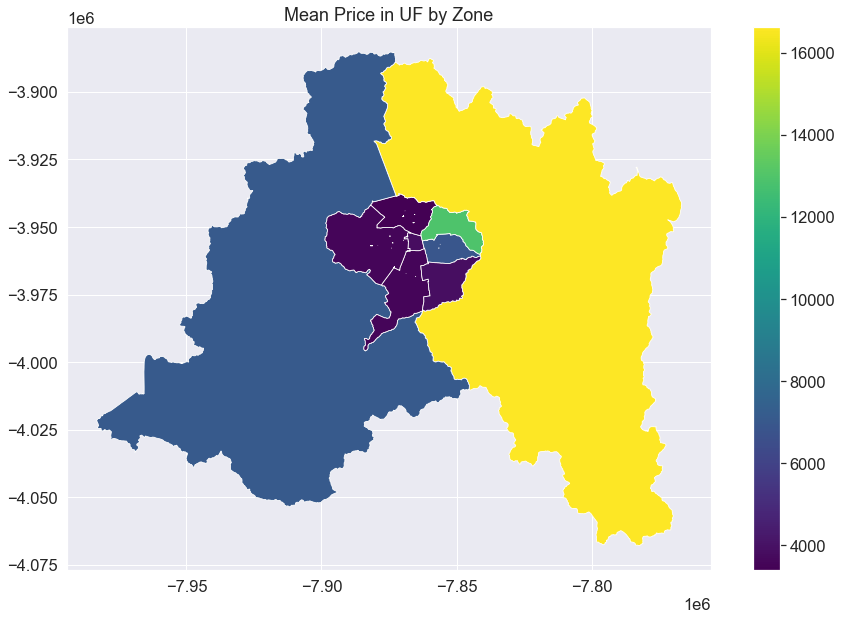

In [53]:
fig, ax = plt.subplots(1, figsize=(15, 10))

zones_merged_df.plot('price_uf', cmap='viridis', linewidth=0.8, ax=ax, legend=True)
plt.title('Mean Price in UF by Zone');

In [54]:
# Save the data with the changes as a new csv file
df.to_csv('analyzed_data.csv', index=False)